In [1]:
import numpy as np
import sympy as sy
from sympy.utilities.codegen import codegen
import control.matlab as cm
import re
import matplotlib.pyplot as plt
from scipy import signal

# Designing RST controller for the harmonic oscillator

## The plant model

array([array([ 1.,  1.]), array([ 1.])], dtype=object)

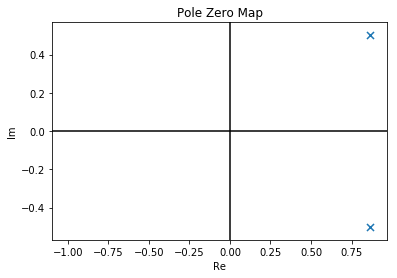

In [2]:
z = sy.symbols('z', real=False)
# The plant model
wh = np.pi/6;
cwh = np.cos(wh);
b1 = 1-cwh;
b2 = b1;
a1 = -2*cwh;
a2 = 1;
Bp = sy.poly(b1*z + b2, z)
Ap = sy.poly( z**2 + a1*z + a2, z)

# Poles and zeros
H = cm.tf([0, b1, b2], [1, a1, a2], 1)
pz = cm.pzmap(H)
np.abs(pz)

## Desired poles

In [3]:
p1 = 0.6
p2 = p1
Ac = sy.poly((z-p1)*(z-p2), z)
Ao = sy.poly(z, z)

## Define and solve Diophantine equation

In [4]:
r1,s0,s1, s2 = sy.symbols('r1,s0,s1, s2', real=True)

# Right hand side
Acl = Ac*Ao

# Left hand side
Rp = sy.poly(z+r1, z)
Sp = sy.poly(s0*z + s1, z)
dioph=(Ap*Rp+Bp*Sp-Acl).all_coeffs()
print(dioph)
print(Acl)
print(Ap*Rp)
print(Ac)
print(Ap*Rp)
print(Ap*Rp + Bp*Sp)

[1.0*r1 + 0.133974596215561*s0 - 0.532050807568877, -1.73205080756888*r1 + 0.133974596215561*s0 + 0.133974596215561*s1 + 0.64, 1.0*r1 + 0.133974596215561*s1]
Poly(1.0*z**3 - 1.2*z**2 + 0.36*z, z, domain='RR')
Poly(1.0*z**3 + (1.0*r1 - 1.73205080756888)*z**2 + (-1.73205080756888*r1 + 1.0)*z + 1.0*r1, z, domain='RR[r1]')
Poly(1.0*z**2 - 1.2*z + 0.36, z, domain='RR')
Poly(1.0*z**3 + (1.0*r1 - 1.73205080756888)*z**2 + (-1.73205080756888*r1 + 1.0)*z + 1.0*r1, z, domain='RR[r1]')
Poly(1.0*z**3 + (1.0*r1 + 0.133974596215561*s0 - 1.73205080756888)*z**2 + (-1.73205080756888*r1 + 0.133974596215561*s0 + 0.133974596215561*s1 + 1.0)*z + 1.0*r1 + 0.133974596215561*s1, z, domain='RR[r1,s0,s1]')


In [5]:
sol = sy.solve(dioph, (r1,s0,s1))
print('r_1 = %f' % sol[r1])
print('s_0 = %f' % sol[s0])
print('s_1 = %f' % sol[s1])

t0 = Ac.evalf(subs={z:1})/Bp.evalf(subs={z:1,})
print('t_0 = %f' % t0)

R = Rp.subs(sol)
S = Sp.subs(sol)
T = t0*Ao

Hc = T*Bp/(Ac*Ao)
Hcc = t0*0.8/Ac
sy.pretty_print(sy.expand(Hc))
sy.pretty_print(sy.expand(Hcc))
sy.pretty_print(Hc.evalf(subs={z:1}))

sy.pretty_print(sy.simplify(Ap*R + Bp*S))

r_1 = 0.314050
s_0 = 1.627180
s_1 = -2.344102
t_0 = 0.597128
0.597128129211021⋅Poly(z, z, domain='ZZ')⋅Poly(0.133974596215561*z + 0.1339745
──────────────────────────────────────────────────────────────────────────────
                           Poly(1.0*z**3 - 1.2*z**2 + 0.36*z, z, domain='RR') 

96215561, z, domain='RR')
─────────────────────────
                         
              0.477702503368817              
─────────────────────────────────────────────
Poly(1.0*z**2 - 1.2*z + 0.36, z, domain='RR')
1.00000000000000
Poly(1.0*z**3 - 1.2*z**2 + 0.360000000000001*z, z, domain='RR')


In [6]:
1.0/0.3125

3.2

In [7]:
num = sy.list2numpy((Ap*R).all_coeffs(), dtype=np.float64)
den = sy.list2numpy((Ac*Ao).all_coeffs(), dtype=np.float64)
print(num)
print(den)
print(type(num[0]))
Hd = cm.tf(num[:-1], den[:-1], -1)
print(Hd)
ystep, t = cm.step(Hd)
plt.figure()
plt.plot(t, ystep)
plt.show()

[ 1.         -1.41800074  0.45604933  0.31405007]
[ 1.   -1.2   0.36  0.  ]
<class 'numpy.float64'>

z^2 - 1.418 z + 0.456
---------------------
  z^2 - 1.2 z + 0.36



ValueError: negative dimensions are not allowed

## Design with incremental controller

In [10]:
# The observer poles: Should be twice as fast as the closed-loop poles
# and critically damped
p1 = 0.6 + 1j*0.3;
p2 = 0.6 - 1j*0.3;
lambda1 = np.log(p1)
omegan = np.abs(lambda1)
zeta = np.real(lambda1) / omegan
po1 = np.exp(-2*omegan)
print(lambda1, omegan, zeta, po1)

(-0.399253848109+0.463647609001j) 0.61186006616 -0.652524768636 0.294133912009


In [11]:
r1,s0,s1,s2 = sy.symbols('r1,s0,s1,s2', real=True)

# Right hand side
Ac = sy.poly((z-p1)*(z-p2), z)

#Ao = sy.poly(z**2, z)
Ao = sy.poly((z-po1)**2, z)
Acl = Ac*Ao

# Left hand side
Rp = sy.poly((z-1)*(z+r1), z)
Sp = sy.poly(s0*z**2 + s1*z + s2, z)
dioph=(Ap*Rp+Bp*Sp-Acl).all_coeffs()
print(dioph)
print(Acl)
print(Ap*Rp)
print(Ac)
print(Ap*Rp)
print(Ap*Rp + Bp*Sp)

[1.0*r1 + 0.133974596215561*s0 - 0.943782983551129, -2.73205080756888*r1 + 0.133974596215561*s0 + 0.133974596215561*s1 + 1.48961466055394, 2.73205080756888*r1 + 0.133974596215561*s1 + 0.133974596215561*s2 - 0.63146176935964, -1.0*r1 + 0.133974596215561*s2 - 0.0389316411871399]
Poly(1.0*z**4 - 1.78826782401775*z**3 + (-1.0*(-0.6 + 0.3*I)*(0.6 + 0.3*I) + 0.792436147014943)*z**2 + (0.588267824017749*(-0.6 + 0.3*I)*(0.6 + 0.3*I) - 0.103817709832373)*z - 0.0865147581936442*(-0.6 + 0.3*I)*(0.6 + 0.3*I), z, domain='EX')
Poly(1.0*z**4 + (1.0*r1 - 2.73205080756888)*z**3 + (-2.73205080756888*r1 + 2.73205080756888)*z**2 + (2.73205080756888*r1 - 1.0)*z - 1.0*r1, z, domain='RR[r1]')
Poly(z**2 - 1.2*z - (-0.6 + 0.3*I)*(0.6 + 0.3*I), z, domain='EX')
Poly(1.0*z**4 + (1.0*r1 - 2.73205080756888)*z**3 + (-2.73205080756888*r1 + 2.73205080756888)*z**2 + (2.73205080756888*r1 - 1.0)*z - 1.0*r1, z, domain='RR[r1]')
Poly(1.0*z**4 + (1.0*r1 + 0.133974596215561*s0 - 2.73205080756888)*z**3 + (-2.73205080756888*r1

In [13]:
sol = sy.solve(dioph, (r1,s0,s1, s2))
sol

{r1: 0.405397451468340,
 s0: 4.01856431958595,
 s1: -6.87021109946348,
 s2: 3.31651749814247}

In [14]:
print('r_1 = %f' % sol[r1])
print('s_0 = %f' % sol[s0])
print('s_1 = %f' % sol[s1])
print('s_2 = %f' % sol[s2])

t0 = Ac.evalf(subs={z:1})/Bp.evalf(subs={z:1,})
print('t_0 = %f' % t0)

R = Rp.subs(sol)
S = Sp.subs(sol)
T = t0*Ao

Hc = T*Bp/(Ac*Ao)
Hcc = t0*0.8/Ac
sy.pretty_print(sy.expand(Hc))
sy.pretty_print(sy.expand(Hcc))
sy.pretty_print(Hc.evalf(subs={z:1}))

sy.pretty_print(sy.simplify(Ap*R + Bp*S))

r_1 = 0.405397
s_0 = 4.018564
s_1 = -6.870211
s_2 = 3.316517
t_0 = 0.933013
0.93301270189222⋅Poly(0.133974596215561*z + 0.133974596215561, z, domain='RR')
──────────────────────────────────────────────────────────────────────────────
                Poly(1.0*z**4 - 1.78826782401775*z**3 + 1.24243614701494*z**2 

⋅Poly(1.0*z**2 - 0.588267824017749*z + 0.0865147581936442, z, domain='RR')
──────────────────────────────────────────────────────────────────────────
- 0.36853823064036*z + 0.0389316411871399, z, domain='RR')                
              0.746410161513776              
─────────────────────────────────────────────
Poly(1.0*z**2 - 1.2*z + 0.45, z, domain='RR')
1.00000000000000
Poly(1.0*z**4 - 1.78826782401775*z**3 + 1.24243614701494*z**2 - 0.368538230640
362*z + 0.0389316411871409, z, domain='RR')


In [ ]:
# Reorganize solution expression for matlab code generation
sol_expr = ('RST_DC_lab', [Bp.all_coeffs()[0], Bp.all_coeffs()[1],
                           Ap.all_coeffs()[1], Ap.all_coeffs()[2],
                           sol[r1], sol[s0], sol[s1], A2p.subs(z, 1)/Bp.subs(z,1), h,np.exp(h*po1) ])  

In [ ]:
# Export to matlab code
[(m_name, m_code)] = codegen(sol_expr, 'octave')

In [ ]:
m_code = m_code.replace("out1", "b0").replace("out2", "b1").replace("out3", "a1").replace("out4", "a2")
m_code = m_code.replace("out5", "r1").replace("out6", "s0").replace("out7", "s1").replace("out8", "t0")
m_code = m_code.replace("out9", "h").replace("out10", "obsPole")
m_code = m_code.replace("function ", "% function ")
m_code = m_code.replace("end", "")
print m_code
with open("/home/kjartan/Dropbox/undervisning/tec/MR2007/labs/dc_rst_design.m", "w") as text_file:
    text_file.write(m_code)

In [ ]:
cm.step?

In [ ]:

G = Km * cm.tf([1], [tau, 1, 0])
Gd = Km * cm.tf([tau*(hpt-1+np.exp(-hpt)), tau*(1-(1+hpt)*np.exp(-hpt))], [1, -(1+np.exp(-hpt)), np.exp(-hpt)], h)
Gd2 = cm.c2d(G, h)
print Gd
print Gd2

In [ ]:
print A2p
print A2p.evalf(subs={z:1})
print Bp
print Bp.evalf(subs={z:1})


In [ ]:
0.3/(5*np.sqrt(2))

In [ ]:
np.exp(-0.21)*np.sin(0.21)

In [ ]:
np.exp(0.03*(-14))

In [ ]:
 0.746*41.8
